In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
results_dir = "[3] Test Input"

output_dir = "[5] Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

In [3]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

all_experiments = set()
for df in dfs.values():
    if 'experiment' in df.columns:
        all_experiments.update(df['experiment'].dropna().unique())

experiments = sorted(all_experiments)
print(f"All experiments found across raw dataframes ({len(experiments)}):")
print(" " + ', '.join(map(str, experiments)))

# ...existing code...

Raw dataframes: ['RESULTS', 'RESULTS_ASR_control', 'RESULTS_MERGED', 'RESULTS_MERGED_ASR_control', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_DATE_ASR_control', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MT10_ASR_control', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_ASR_control', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE_ASR_control', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_T10_ASR_control', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_ASR_control', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE_ASR_control', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder', 'SegmentOrder_ASR_control']
Fit dataframes: []
Found 23 raw and 0 fit dataframes in [3] Test Input.

Found 1 experiments, 9 variables and 4 parameters:
 ASR_control
 reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC
 animal, sex, date, experiment
All experiments found across raw dataframes (19):
 ASR_control, gap_depth, gap_duration_10, gap_duration_20, gap_duration_4, gap_duration_50, gap_duration_8, 

---

In [4]:
# Count how many peakTime values are exactly 30 in RESULTS_MTT_MERGED (out of 324)
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
count_30 = (df['peakTime'] == 30).sum()
total = len(df)
print(f"Number of peakTime values equal to 30: {count_30} out of {total} ({count_30/total:.2%})")

Number of peakTime values equal to 30: 125 out of 306 (40.85%)


---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

## Average Reaction Time

In [5]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8, and print the maximum value

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']
vals = df['reactionTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
print(f"Maximum reaction time (IQR filtered): {filtered.max():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Reaction time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Reaction time is significantly higher than 6.")
else:
    print("Reaction time is not significantly higher than 6 or 8.")

Mean reaction time (IQR filtered): 10.67
Maximum reaction time (IQR filtered): 13.60
T-test vs 8: statistic=46.302, p-value=1.897e-138
T-test vs 6: statistic=81.033, p-value=2.384e-205
Reaction time is significantly higher than 8.


In [6]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean reaction time (IQR filtered): 10.84
T-test vs 8: statistic=32.978, p-value=1.187e-70
T-test vs 6: statistic=56.232, p-value=1.543e-102
Reaction time is significantly higher than 8.

Sex: male
Mean reaction time (IQR filtered): 10.46
T-test vs 8: statistic=36.794, p-value=2.048e-75
T-test vs 6: statistic=66.751, p-value=1.636e-110
Reaction time is significantly higher than 8.


In [51]:
import pandas as pd
from scipy.stats import ttest_1samp, t
import numpy as np

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    n = len(filtered)
    mean = filtered.mean()
    sem = filtered.sem()
    # 95% confidence interval
    ci = t.interval(0.95, n-1, loc=mean, scale=sem) if n > 1 else (np.nan, np.nan)
    print(f"\nSex: {sex}")
    print(f"Mean reaction time (IQR filtered): {mean:.2f}")
    print(f"95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean reaction time (IQR filtered): 10.84
95% CI: (10.67, 11.01)
T-test vs 8: statistic=32.978, p-value=1.187e-70
T-test vs 6: statistic=56.232, p-value=1.543e-102
Reaction time is significantly higher than 8.

Sex: male
Mean reaction time (IQR filtered): 10.46
95% CI: (10.32, 10.59)
T-test vs 8: statistic=36.794, p-value=2.048e-75
T-test vs 6: statistic=66.751, p-value=1.636e-110
Reaction time is significantly higher than 8.


In [7]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']
vals = df['peakTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Peak time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Peak time is significantly higher than 6.")
else:
    print("Peak time is not significantly higher than 6 or 8.")

Mean peak time (IQR filtered): 30.29
T-test vs 8: statistic=705.727, p-value=0.000e+00
T-test vs 6: statistic=769.039, p-value=0.000e+00
Peak time is significantly higher than 8.


In [8]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['peakTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Peak time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Peak time is significantly higher than 6.")
    else:
        print("Peak time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 30.22
T-test vs 8: statistic=766.974, p-value=3.428e-238
T-test vs 6: statistic=835.994, p-value=5.111e-243
Peak time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 30.13
T-test vs 8: statistic=269.230, p-value=3.206e-151
T-test vs 6: statistic=293.566, p-value=3.674e-155
Peak time is significantly higher than 8.


---

## Repetition Differences

In [9]:
# ...existing code...

# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (parametric, assume normality)
import ast
from scipy.stats import f_oneway

def test_repetition_effect_parametric(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # ANOVA (parametric) test across repetitions
        stat, p = f_oneway(*rep_groups)
        if p < alpha:
            mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'anova', 'mean_diff': mean_diff})
    return pd.DataFrame(results)

repetition_effects_parametric = test_repetition_effect_parametric(dfs['RESULTS'], variables)
test_repetition_parametric = pd.DataFrame(repetition_effects_parametric)

print(test_repetition_parametric) if not repetition_effects_parametric.empty else print("No significant repetition effects found for any variable (parametric).")
test_repetition_parametric.to_excel(os.path.join(output_dir, "TEST_REPETITION_PARAMETRIC.xlsx"), index=False)

No significant repetition effects found for any variable (parametric).


# ---> merge across repetitions

---

## Intratrial Differences

In [10]:
# Check for intratrial differences: do variables increase or decrease across one animal's experiment?

import pandas as pd
from scipy.stats import linregress

# Load the lookup table DataFrame (assume it's named "SegmentOrder.xlsx" and in Analyzer Results)
lookup_path = os.path.join("[1] Peakfinder Results", "SegmentOrder.xlsx")
lookup_df = pd.read_excel(lookup_path)

# Load main results
df = dfs['RESULTS_MERGED']

# For each animal and date, check variable trends across experiment order
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
trend_results = []

# ...existing code...

for (animal, date), group in lookup_df.groupby(['animal', 'date']):
    order_map = {row['experiment']: row['order_index'] for _, row in group.iterrows()}
    df_sub = df[(df['animal'] == animal) & (df['date'] == date)].copy()
    df_sub['order_index'] = df_sub['experiment'].map(order_map)
    df_sub = df_sub[df_sub['order_index'].notnull()]
    df_sub = df_sub.sort_values('order_index')
    n_trials = len(df_sub)
    for var in variables:
        vals = df_sub[var].dropna()
        order = df_sub['order_index'].loc[vals.index]
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order, vals)
            # Percent change per minute
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            percent_change_per_minute = percent_change / 30 if percent_change is not None else None
            trend_results.append({
                'animal': animal,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change,
                'percent_change_per_minute': percent_change_per_minute
            })

# ...existing code...

trend_df = pd.DataFrame(trend_results)
trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results

print(trend_df)
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

      animal     date      variable  slope_per_trial         r         p  \
0    Animal1  April16           tau        -0.602164 -0.566128  0.017835   
1   Animal10    May20  reactionTime         0.065717  0.509968  0.036498   
2   Animal15   June26    difference        -0.163589 -0.501821  0.040123   
3    Animal2   June26  reactionTime        -0.010638 -0.498668  0.041596   
4    Animal2    May20           tau         0.818708  0.530717  0.028391   
5    Animal4    May20     peakValue         0.687755  0.494759  0.043480   
6    Animal4    May20          PTPA         0.693826  0.496221  0.042768   
7    Animal4    May20          PTTA         0.687562  0.523818  0.030915   
8    Animal4    May20           RMS         0.201263  0.504985  0.038684   
9    Animal6  April16  reactionTime         0.026454  0.582511  0.014139   
10   Animal6  April16     peakValue        -0.290914 -0.485479  0.048210   
11   Animal6  April16          PTPA        -0.292549 -0.483580  0.049224   
12   Animal6

In [11]:
import pandas as pd

# Load significant intratrial trends
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Define metrics
strength_metrics = ['AUC', 'PTPA', 'PTTA', 'RMS', 'peakValue']
reaction_metrics = ['reactionTime', 'peakTime']

# Only keep strength metrics
trend_strength = trend_df[trend_df['variable'].isin(strength_metrics)]
avg_strength_percent_change_per_minute = trend_strength['percent_change_per_minute'].mean()
print(f"Average percent change per minute (strength metrics, significant results): {avg_strength_percent_change_per_minute:.3f}")

# Only keep reaction metrics
trend_reaction = trend_df[trend_df['variable'].isin(reaction_metrics)]
avg_reaction_percent_change_per_minute = trend_reaction['percent_change_per_minute'].mean()
print(f"Average percent change per minute (reaction metrics, significant results): {avg_reaction_percent_change_per_minute:.3f}")

Average percent change per minute (strength metrics, significant results): -0.036
Average percent change per minute (reaction metrics, significant results): 0.363


---

In [12]:
import pandas as pd
import statsmodels.formula.api as smf

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for var in variables:
    print(f"\n=== Mixed Linear Model for {var} ===")
    try:
        model = smf.mixedlm(f'{var} ~ C(sex) + C(date) + C(experiment)', data=df, groups=df['animal']).fit()
        print(model.summary())
    except Exception as e:
        print(f"Could not fit model for {var}: {e}")


=== Mixed Linear Model for reactionTime ===
                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      reactionTime
No. Observations:        306          Method:                  REML        
No. Groups:              6            Scale:                   0.9539      
Min. group size:         51           Log-Likelihood:          -435.2799   
Max. group size:         51           Converged:               Yes         
Mean group size:         51.0                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        10.836    0.386 28.071 0.000 10.079 11.593
C(sex)[T.male]                   -0.341    0.431 -0.792 0.428 -1.186  0.503
C(date)[T.June26]                -0.774    0.137 -5.661 0.000 

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        PTPA      
No. Observations:         306            Method:                    REML      
No. Groups:               6              Scale:                     677.4086  
Min. group size:          51             Log-Likelihood:            -1376.7780
Max. group size:          51             Converged:                 Yes       
Mean group size:          51.0                                                
------------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                         72.072   16.910  4.262 0.000  38.929 105.215
C(sex)[T.male]                    69.025   22.186  3.111 0.002  25.542 112.508
C(date)[T.June26]                 54.772    3.645 15.029 0.000  47.629  6

# Summary of Mixed Linear Model Results

### Reaction Metrics
- **reactionTime**
  - **Sex:** No significant effect.
  - **Date:** Both June26 and May20 are significantly lower than the reference (p < 0.001).
  - **Experiment:** Most not significant, but offset_PPI_14, _20, _6, _8 show significantly higher reactionTime (p < 0.05). tone_in_noise is significantly lower (p = 0.002).
- **peakTime & difference**
  - No significant effects for sex, date, or experiment.

### Strength Metrics (peakValue, PTPA, PTTA, RMS, AUC)
- **Sex:** Males have significantly higher values for all except tau and AUC (p < 0.05).
- **Date:** Both June26 and May20 are significantly higher than the reference (p < 0.001).
- **Experiment:** offset_PPI variants and tone_in_noise are significantly lower (p < 0.05 for many variants). Other experiments mostly not significant.

### tau
- **Sex:** Males have significantly lower tau (p = 0.017).
- **Date:** May20 is significantly lower than reference (p = 0.002).
- **Experiment:** No significant effects.

### Summary
- Sex and date strongly affect strength metrics, but not reaction metrics.
- offset_PPI and tone_in_noise experiments consistently reduce strength metrics and reactionTime.
- peakTime and difference are not significantly affected by any factor.

# ---> reaction time is the best reaction metric
# ---> AUC might be useful for avoiding sex differences
# ---> males have higher strength
# ---> recording date affects strength most
# ---> especially tone in noise and offset PPI cause lower ASR strength (in line with %PPI results)
# ---> tau varies by sex and date, much like strength, but unlike strength is not affected by experiment

---

## Date Differences

In [13]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

date_results_parametric = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Parametric ANOVA for all metrics
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None
            if p < 0.05:
                try:
                    # Tukey HSD posthoc (parametric)
                    tukey = sp.posthoc_tukey_hsd(df_sex, val_col=var, group_col='date')
                    min_p = tukey.replace(0, float('nan')).min().min()
                    idx = tukey.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    mean_diff = vals1.mean() - vals2.mean()
                    # Cohen's d for effect size
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    eff = mean_diff / pooled_std if pooled_std != 0 else None
                    posthoc_p = min_p
                    posthoc_test = "Tukey HSD"
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
        else:
            stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        date_results_parametric.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date_parametric = pd.DataFrame(date_results_parametric)
print(test_date_parametric)

test_date_parametric.to_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       sex      variable       stat             p  significant     posthoc_p  \
0   female  reactionTime  21.205537  7.755139e-09         True  7.925448e-09   
1   female      peakTime   4.762703  9.876548e-03         True  6.824804e-03   
2   female    difference  16.627420  3.003899e-07         True  2.810040e-06   
3   female     peakValue  57.838398  2.400615e-19         True  4.551914e-15   
4   female          PTPA  57.888775  2.333310e-19         True  4.551914e-15   
5   female          PTTA  53.782140  2.457095e-18         True  4.551914e-15   
6   female           RMS  64.011862  7.956192e-21         True  4.551914e-15   
7   female           tau   0.264737  7.677658e-01        False           NaN   
8   female           AUC  96.889035  9.682372e-28         True  4.551914e-15   
9     male  reactionTime   0.886156  4.143842e-01        False           NaN   
10    male      peakTime   2.363237  9.761064e-02        False           NaN   
11    male    difference   1.273014  2.8

In [14]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

date_results_merged_sex_parametric = []

for var in variables:
    # Parametric ANOVA for all metrics, merged by sex
    groups = [group[var].dropna().values for _, group in df.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
    if len(groups) > 1:
        stat, p = f_oneway(*groups)
        if p < 0.05:
            try:
                tukey = sp.posthoc_tukey_hsd(df, val_col=var, group_col='date')
                min_p = tukey.replace(0, float('nan')).min().min()
                idx = tukey.stack().idxmin()
                date1, date2 = idx
                vals1 = df[df['date'] == date1][var].dropna()
                vals2 = df[df['date'] == date2][var].dropna()
                mean_diff = vals1.mean() - vals2.mean()
                pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                eff = mean_diff / pooled_std if pooled_std != 0 else None
                posthoc_p = min_p
                posthoc_test = "Tukey HSD"
            except Exception:
                posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
    date_results_merged_sex_parametric.append({
        'variable': var,
        'stat': stat,
        'p': p,
        'significant': p is not None and p < 0.05,
        'posthoc_p': posthoc_p,
        'posthoc_test': posthoc_test,
        'date1': date1,
        'date2': date2,
        'effect_strength': eff,
        'mean_diff': mean_diff
    })

test_date_merged_sex_parametric = pd.DataFrame(date_results_merged_sex_parametric)
print(test_date_merged_sex_parametric)

test_date_merged_sex_parametric.to_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       variable       stat             p  significant     posthoc_p  \
0  reactionTime  13.462482  2.504141e-06         True  5.650678e-06   
1      peakTime   0.383957  6.814918e-01        False           NaN   
2    difference   0.771595  4.631813e-01        False           NaN   
3     peakValue  32.102077  2.264951e-13         True  1.108003e-13   
4          PTPA  32.406919  1.761597e-13         True  8.859580e-14   
5          PTTA  30.730354  7.054642e-13         True  4.370948e-13   
6           RMS  28.716370  3.799154e-12         True  1.340816e-12   
7           tau   2.949079  5.389365e-02        False           NaN   
8           AUC  31.959162  2.548555e-13         True  7.793766e-14   

  posthoc_test    date1   date2  effect_strength    mean_diff  
0    Tukey HSD  April16  June26         0.676572     0.774183  
1         None     None    None              NaN          NaN  
2         None     None    None              NaN          NaN  
3    Tukey HSD  April16  June26  

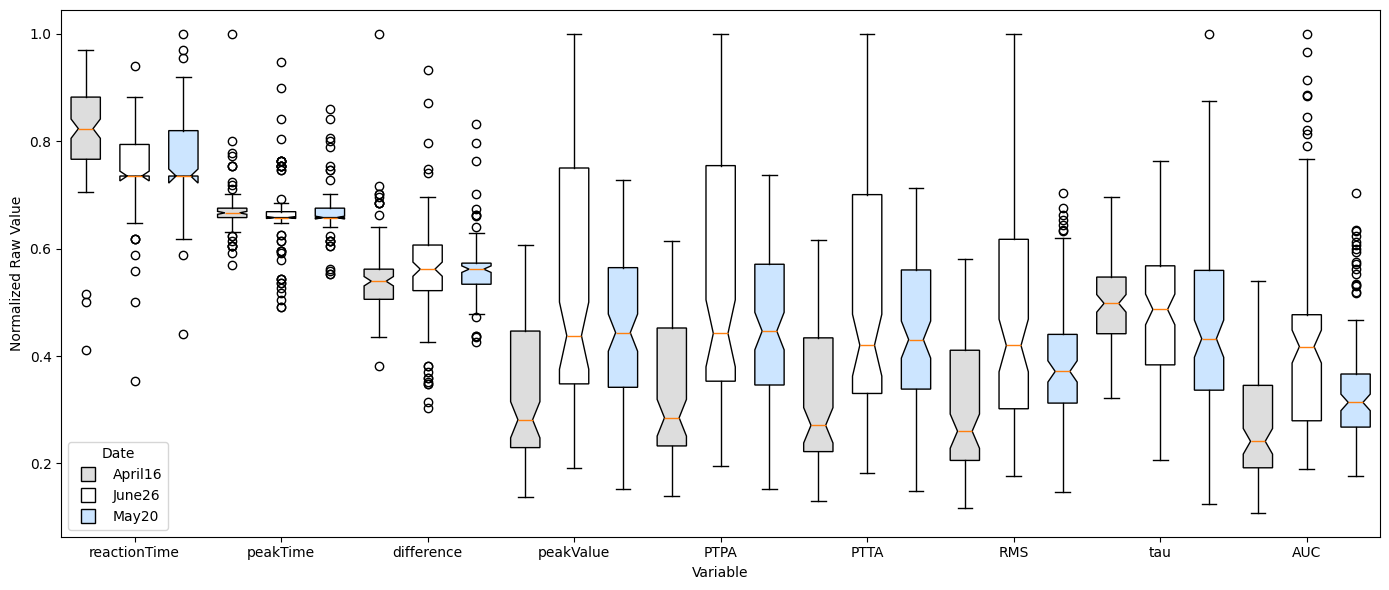

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"))
df = dfs['RESULTS_MERGED']

# Only keep significant results
sig = test_date#[test_date['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        vals = df[df['date'] == date][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*len(dates) + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append(['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC'][j % 5])  # Color by date

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*len(dates)+(len(dates)-1)/2 for i in range(len(variables))], variables)
plt.ylabel('Normalized Raw Value')
plt.xlabel('Variable')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label=dates[0], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label=dates[1], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#CCE5FF', label=dates[2], linestyle='None')
], title='Date', loc='lower left')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]

# Calculate mean for each variable, grouped by date and sex
mean_table = df.groupby(['date', 'sex'])[variables].mean().reset_index()

print(mean_table)

# Optionally, save to Excel
mean_table.to_excel(os.path.join(output_dir, "MEAN_VARIABLES_BY_DATE_SEX.xlsx"), index=False)

      date     sex  reactionTime   peakTime  difference   peakValue  \
0  April16  female     11.535948  30.149020   18.613072   63.007190   
1  April16    male     10.541830  31.098693   20.556863  124.062418   
2   June26  female     10.135294  30.596078   20.460784  106.546078   
3   June26    male     10.394118  30.013072   19.618954  190.527451   
4    May20  female     10.545098  31.101961   20.556863   95.866993   
5    May20    male     10.256209  29.758824   19.502614  159.165033   

         PTPA        PTTA        RMS         tau           AUC  
0   63.347232   56.633121  24.845078  155.657944   6515.070654  
1  123.598686  112.008539  50.005042  134.892016  12336.653824  
2  106.495833   95.374990  44.323745  159.536186  12713.435000  
3  189.993833  171.015856  72.285173  115.009729  17486.907810  
4   95.941650   86.598539  38.481294  156.793105  10121.970948  
5  159.268278  144.490160  58.856324  107.865255  13981.300533  


In [17]:
import pandas as pd

df = dfs['RESULTS_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']

# Calculate mean for each metric by date
mean_by_date = df.groupby('date')[strength_metrics].mean()

# Calculate mean difference between dates for each metric
mean_diff = mean_by_date.max() - mean_by_date.min()
mean_diff = mean_diff.rename('mean_difference')

# Combine for display
result = mean_by_date.T
result['mean_difference'] = mean_diff

print(result)

# Optionally save to Excel
result.to_excel(os.path.join(output_dir, "STRENGTH_METRIC_MEAN_DIFF_BY_DATE.xlsx"))

date           April16        June26         May20  mean_difference
peakValue    93.534804    148.536765    127.516013        55.001961
PTPA         93.472959    148.244833    127.604964        54.771874
PTTA         84.320830    133.195423    115.544350        48.874593
RMS          37.425060     58.304459     48.668809        20.879399
tau         145.274980    137.272958    132.329180        12.945801
AUC        9425.862239  15100.171405  12051.635740      5674.309167


In [18]:
# Count how many sex/variable groups show significant date deviations

import pandas as pd
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            if p < 0.05:
                significant_count += 1
                results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/variable groups with significant date deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_DATE_SPLIT.xlsx"), index=False)

Number of sex/variable groups with significant date deviations: 16


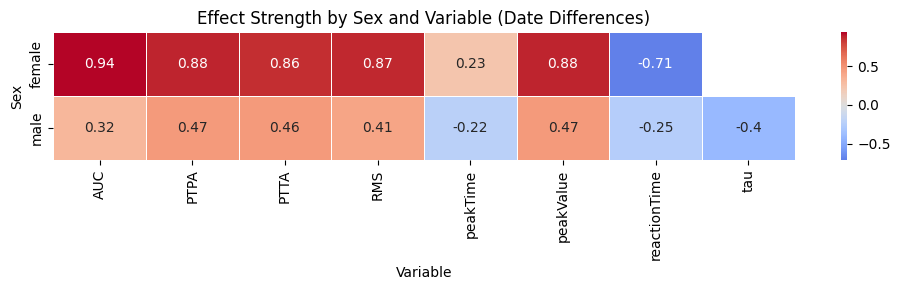

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*8 + ["male"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau",
                 "AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "effect_strength": [0.940329, 0.877915, 0.859396, 0.871742, 0.229424, 0.878944, -0.711248, np.nan,
                       0.316187, 0.466392, 0.463649, 0.414952, -0.223594, 0.467078, -0.247942, -0.403978]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex x variable)
heatmap_data = df.pivot(index="sex", columns="variable", values="effect_strength")

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex and Variable (Date Differences)")
plt.ylabel("Sex")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

In [20]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): -1.508
Average effect strength (male): -0.822
Females have 1.84x stronger effect on average (ratio), or -0.686 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

In [21]:
# ...existing code...

import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            # Cohen's d for effect size
            pooled_std = ((vals_male.std(ddof=1) ** 2 + vals_female.std(ddof=1) ** 2) / 2) ** 0.5
            eff = mean_diff / pooled_std if pooled_std != 0 else None
            # Tukey HSD posthoc
            try:
                data = pd.DataFrame({var: pd.concat([vals_male, vals_female]),
                                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)})
                tukey = sp.posthoc_tukey_hsd(data, val_col=var, group_col='group')
                posthoc_p = tukey.loc['male', 'female']
                posthoc_test = "Tukey HSD"
            except Exception:
                posthoc_p = None
                posthoc_test = "Tukey HSD"
        else:
            stat, p, eff, posthoc_p, posthoc_test = None, None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'mean_diff': mean_diff,
            'test': 'ttest_ind'
        })

test_sex = pd.DataFrame(sex_diff_results)
print(test_sex)

test_sex.to_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       date      variable       stat             p  significant  \
0   April16  reactionTime  -4.840029  7.697609e-06         True   
1   April16      peakTime   2.248310  2.845826e-02         True   
2   April16    difference   4.030097  1.629377e-04         True   
3   April16     peakValue  15.857726  3.073461e-25         True   
4   April16          PTPA  15.974820  1.481375e-25         True   
5   April16          PTTA  15.978218  1.300955e-25         True   
6   April16           RMS  14.654871  5.703875e-23         True   
7   April16           tau  -5.615474  3.573523e-07         True   
8   April16           AUC  12.172379  6.814637e-19         True   
9    June26  reactionTime   1.146289  2.548667e-01        False   
10   June26      peakTime  -0.875351  3.847461e-01        False   
11   June26    difference  -1.104425  2.732507e-01        False   
12   June26     peakValue   8.301922  1.172935e-11         True   
13   June26          PTPA   8.344346  9.987295e-12         Tru

In [22]:
import pandas as pd

# Replace with your actual DataFrame if needed
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))
# For your pasted data, assume it's in a DataFrame called df

# Only keep numeric columns for averaging
cols_to_avg = ['stat', 'p', 'effect_strength', 'mean_diff']
avg_df = df.groupby('variable')[cols_to_avg].mean().reset_index()

# Optionally, keep the first posthoc_test and test type for each variable
for col in ['posthoc_test', 'test']:
    avg_df[col] = df.groupby('variable')[col].first().values

print(avg_df)
avg_df.to_excel(os.path.join(output_dir, "TEST_SEX_AVG_ACROSS_DATES_PARAMETRIC.xlsx"), index=False)

       variable       stat             p  effect_strength    mean_diff  \
0           AUC   7.054158  1.001429e-04         1.396931  4818.128522   
1          PTPA  12.271497  3.329098e-12         2.430118    69.025361   
2          PTTA  12.169862  7.401894e-12         2.409992    62.969302   
3           RMS   9.806824  5.823404e-09         1.942040    24.498807   
4    difference   0.169632  9.696545e-02         0.033592     0.015904   
5      peakTime  -0.647771  1.381589e-01        -0.128278    -0.325490   
6     peakValue  12.207448  3.909783e-12         2.417435    69.444880   
7  reactionTime  -1.665079  1.503764e-01        -0.329735    -0.341394   
8           tau  -6.071495  1.423227e-07        -1.202335   -38.073412   

  posthoc_test       test  
0    Tukey HSD  ttest_ind  
1    Tukey HSD  ttest_ind  
2    Tukey HSD  ttest_ind  
3    Tukey HSD  ttest_ind  
4    Tukey HSD  ttest_ind  
5    Tukey HSD  ttest_ind  
6    Tukey HSD  ttest_ind  
7    Tukey HSD  ttest_ind  
8    Tu

In [23]:
import pandas as pd

# Load the results
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))

# Columns to summarize
cols_to_range = ['stat', 'p', 'effect_strength', 'mean_diff']

# Group by variable and get mean for stat/p, min/max for effect_strength/mean_diff
summary = df.groupby('variable').agg(
    stat_mean=('stat', 'mean'),
    p_mean=('p', 'mean'),
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max'),
    posthoc_test=('posthoc_test', 'first'),
    test=('test', 'first')
).reset_index()

print(summary)
summary.to_excel(os.path.join(output_dir, "TEST_SEX_RANGE_ACROSS_DATES_PARAMETRIC.xlsx"), index=False)

       variable  stat_mean        p_mean  effect_strength_min  \
0           AUC   7.054158  1.001429e-04             0.758092   
1          PTPA  12.271497  3.329098e-12             1.652427   
2          PTTA  12.169862  7.401894e-12             1.611968   
3           RMS   9.806824  5.823404e-09             1.275232   
4    difference   0.169632  9.696545e-02            -0.478593   
5      peakTime  -0.647771  1.381589e-01            -0.656720   
6     peakValue  12.207448  3.909783e-12             1.644025   
7  reactionTime  -1.665079  1.503764e-01            -0.958469   
8           tau  -6.071495  1.423227e-07            -1.339418   

   effect_strength_max  mean_diff_min  mean_diff_max posthoc_test       test  
0             2.410490    3859.329585    5821.583170    Tukey HSD  ttest_ind  
1             3.163486      60.251454      83.498000    Tukey HSD  ttest_ind  
2             3.164159      55.375418      75.640866    Tukey HSD  ttest_ind  
3             2.902097      20.37

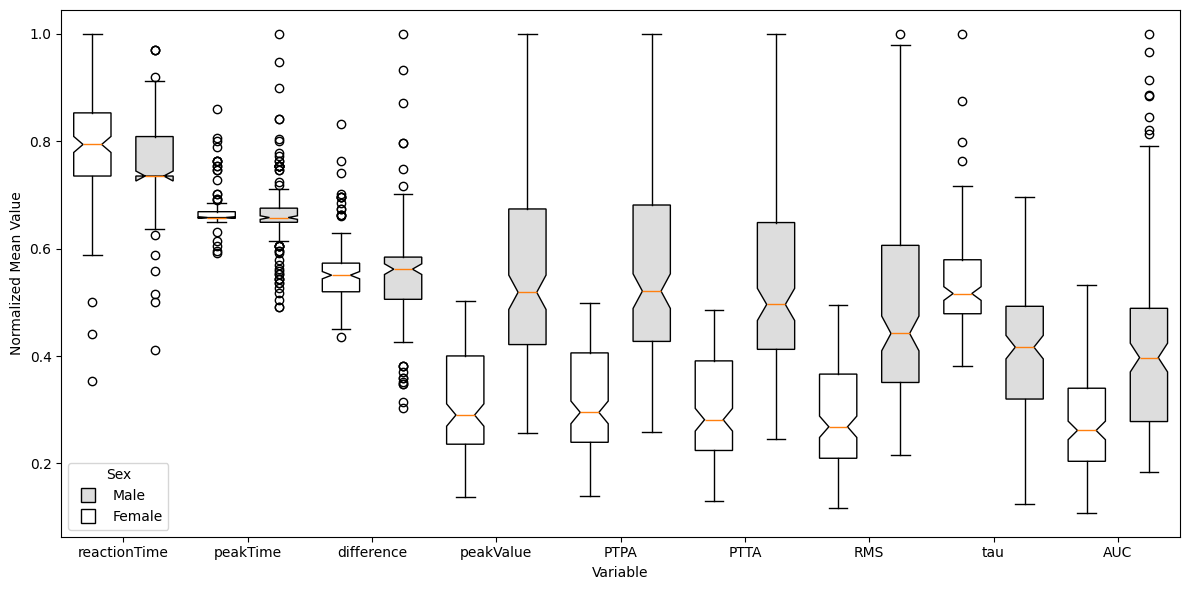

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))
df = dfs['RESULTS_MERGED']

# Only keep significant results
sig = test_sex#[test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/sex
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, sex in enumerate(sexes):
        vals = df[df['sex'] == sex][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*2 + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append('#DDDDDD' if sex == 'male' else '#FFFFFF')  # Gray for male, white for female

plt.figure(figsize=(12, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*2+0.5 for i in range(len(variables))], variables)#, rotation=45)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable')
#plt.title('Normalized Boxplot of Raw Values by Variable and Sex (Significant Results Only)')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label='Male', linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label='Female', linestyle='None')
], title='Sex', loc='lower left')
plt.tight_layout()
plt.show()

In [25]:
# Count how many date/variable groups show significant sex deviations, split by strength and reaction metrics (parametric, assume normality)

import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in df.columns if v not in strength_metrics + ['animal', 'experiment', 'sex', 'date', 'IPI']]

results_strength = []
results_reaction = []
count_strength = 0
count_reaction = 0

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    # Strength metrics
    for var in strength_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            if p < 0.05:
                count_strength += 1
                results_strength.append({'date': date, 'variable': var, 'stat': stat, 'p': p})
    # Reaction metrics
    for var in reaction_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            if p < 0.05:
                count_reaction += 1
                results_reaction.append({'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Significant sex deviations (strength metrics): {count_strength}")
print(f"Significant sex deviations (reaction metrics): {count_reaction}")

pd.DataFrame(results_strength).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_STRENGTH_PARAMETRIC.xlsx"), index=False)
pd.DataFrame(results_reaction).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_REACTION_PARAMETRIC.xlsx"), index=False)

Significant sex deviations (strength metrics): 18
Significant sex deviations (reaction metrics): 5


# ---> strong effect of sex on strength
# ---> weak effect of sex on reaction

---

## Recording Order Differences

In [26]:
# ...existing code...

import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                # Cohen's d for effect size
                pooled_std = ((vals_early.std(ddof=1) ** 2 + vals_late.std(ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    tukey = sp.posthoc_tukey_hsd(data, val_col=metric, group_col='group')
                    posthoc_p = tukey.loc['early', 'late']
                    posthoc_test = 'Tukey HSD'
                except Exception:
                    posthoc_p = None
                    posthoc_test = 'Tukey HSD'
                results.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'test': 'ttest_ind',
                    'stat': stat,
                    'p': p,
                    'effect_strength': effect_strength,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'significant': p < 0.05,
                    'mean_diff': mean_diff
                })

test_rec_order_parametric = pd.DataFrame(results)

# Count significant results per metric
counts = test_rec_order_parametric.groupby('metric')['significant'].sum().reset_index()
counts = counts.rename(columns={'significant': 'significant_count'})
print(counts)

counts.to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_COUNTS_PARAMETRIC.xlsx"), index=False)
print(test_rec_order_parametric)
# ...existing code...

         metric  significant_count
0           AUC                  5
1          PTPA                  3
2          PTTA                  3
3           RMS                  5
4    difference                  2
5      peakTime                  3
6     peakValue                  3
7  reactionTime                  3
8           tau                  4
       sex     date        metric       test       stat             p  \
0   female  April16  reactionTime  ttest_ind   3.085826  3.781136e-03   
1   female  April16      peakTime  ttest_ind  -4.325908  8.989450e-05   
2   female  April16    difference  ttest_ind  -5.965908  4.581443e-07   
3   female  April16     peakValue  ttest_ind  -1.764391  8.398003e-02   
4   female  April16          PTPA  ttest_ind  -1.773997  8.236476e-02   
5   female  April16          PTTA  ttest_ind  -1.039974  3.035068e-01   
6   female  April16           RMS  ttest_ind  -2.575215  1.326489e-02   
7   female  April16           tau  ttest_ind  -2.331505  2.598669e

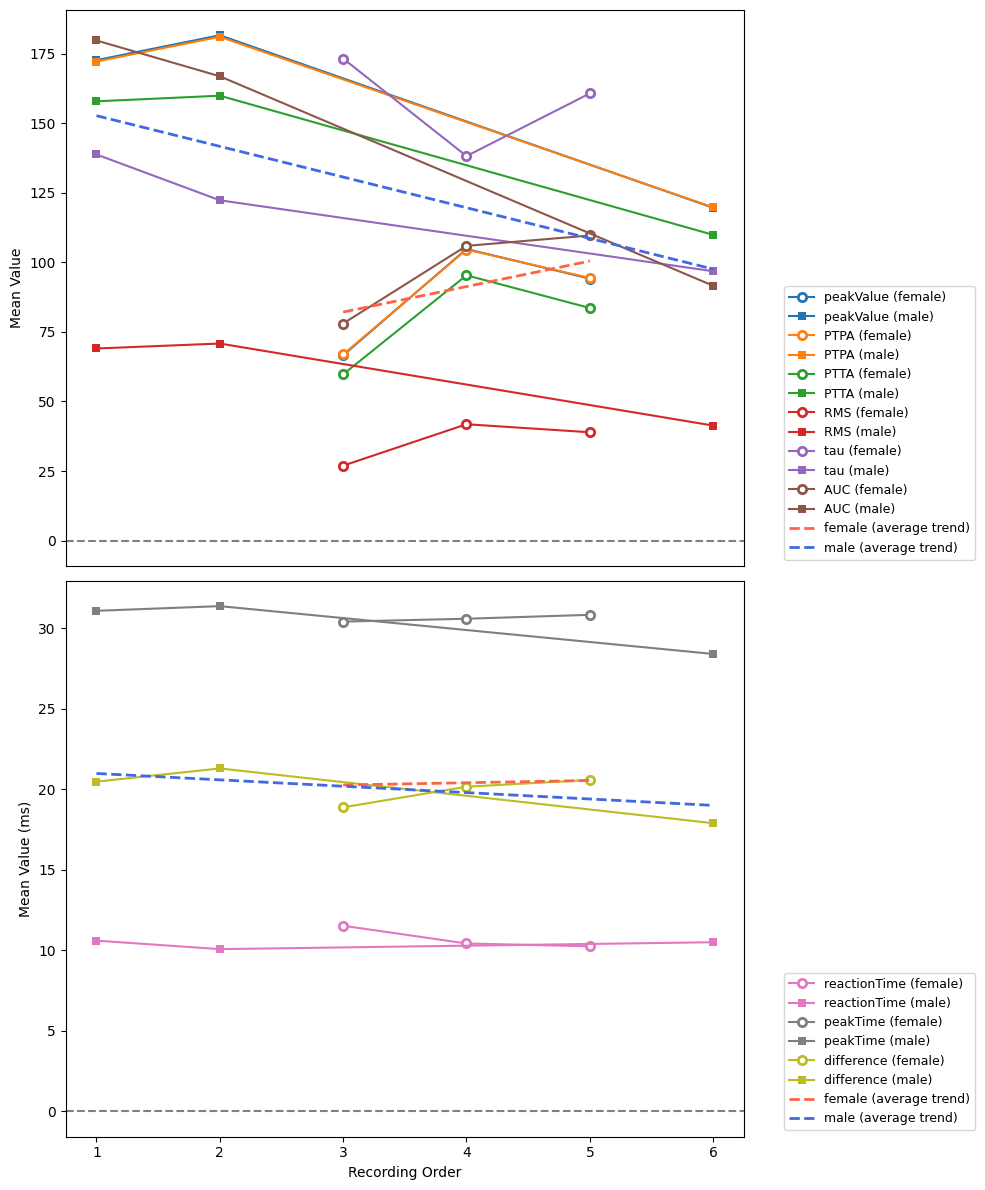

Trendline slopes (average across metrics per group):
Reaction Metrics | female: slope = 0.1405
Reaction Metrics | male: slope = -0.3964
Strength Metrics | female: slope = 9.1645
Strength Metrics | male: slope = -11.0216


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

df = dfs['RESULTS_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']


df_plot = df.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

metric_groups = {
    'Strength Metrics': strength_metrics,
    'Reaction Metrics': reaction_metrics
}

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for group in metric_groups.values():
    for metric in group:
        if metric not in metric_color_map:
            metric_color_map[metric] = next(color_cycle)

trendline_slopes = []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Set custom label for AUC to indicate scaling
def get_metric_label(metric):
    return "AUC" if metric == "AUC" else metric

# Bottom plot: Reaction Metrics
group_name = 'Reaction Metrics'
metrics = reaction_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax2.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax2.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)
            
# Plot total average trendlines per sex and print slope (bottom)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax2.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })

# Top plot: Strength Metrics (including scaled AUC)
group_name = 'Strength Metrics'
metrics = strength_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax1.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax1.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)

# Plot total average trendlines per sex and print slope (top)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax1.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })
        
ax1.set_ylabel('Mean Value')
ax1.axhline(0, color='gray', linestyle='--')
ax1.legend(loc='lower left',  bbox_to_anchor=(1.05, 0), fontsize=9)
ax1.set_xticks(orders)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)



# ...existing code...
ax1.set_xticks(orders)
ax1.set_xticklabels([])  # Hide x tick labels for top plot
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.set_xlabel('Recording Order')
ax2.set_xticks(orders)
ax2.set_xticklabels([str(o) for o in orders])  # Show x tick labels for bottom plot
ax2.set_ylabel('Mean Value (ms)')
ax2.axhline(0, color='gray', linestyle='--')
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0), fontsize=9)
plt.tight_layout()
plt.show()
# ...existing code...

# Print out the slopes of the trendlines
print("Trendline slopes (average across metrics per group):")
for t in trendline_slopes:
    print(f"{t['group']} | {t['sex']}: slope = {t['slope']:.4f}")
# ...existing code...

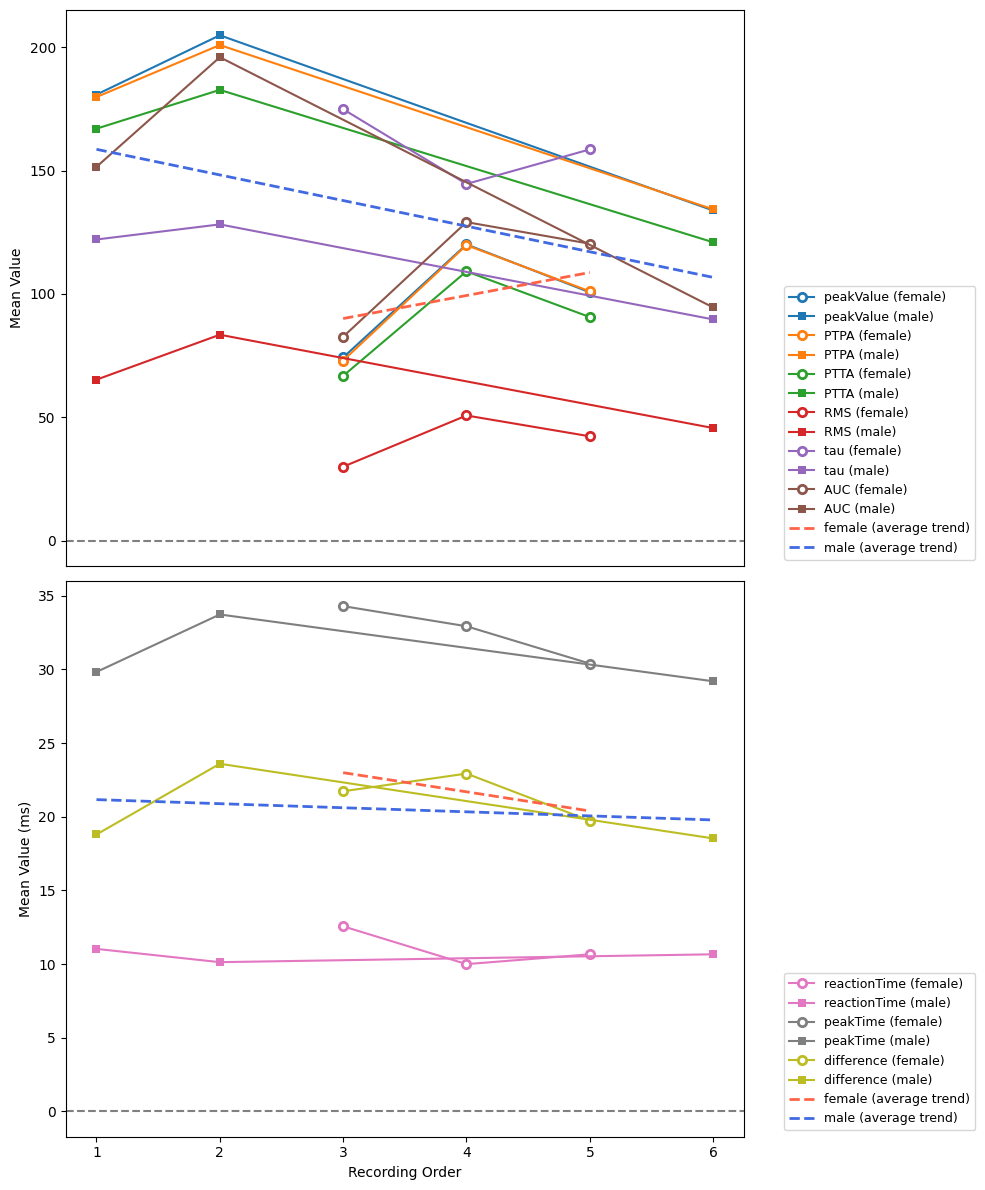

Trendline slopes (average across metrics per group):
Reaction Metrics | female: slope = -1.3000
Reaction Metrics | male: slope = -0.2762
Strength Metrics | female: slope = 9.3362
Strength Metrics | male: slope = -10.3856


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

df = dfs['RESULTS_MERGED_ASR_control']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']


df_plot = df.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

metric_groups = {
    'Strength Metrics': strength_metrics,
    'Reaction Metrics': reaction_metrics
}

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for group in metric_groups.values():
    for metric in group:
        if metric not in metric_color_map:
            metric_color_map[metric] = next(color_cycle)

trendline_slopes = []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Set custom label for AUC to indicate scaling
def get_metric_label(metric):
    return "AUC" if metric == "AUC" else metric

# Bottom plot: Reaction Metrics
group_name = 'Reaction Metrics'
metrics = reaction_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax2.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax2.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)
            
# Plot total average trendlines per sex and print slope (bottom)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax2.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })

# Top plot: Strength Metrics (including scaled AUC)
group_name = 'Strength Metrics'
metrics = strength_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax1.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax1.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)

# Plot total average trendlines per sex and print slope (top)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax1.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })
        
ax1.set_ylabel('Mean Value')
ax1.axhline(0, color='gray', linestyle='--')
ax1.legend(loc='lower left',  bbox_to_anchor=(1.05, 0), fontsize=9)
ax1.set_xticks(orders)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)



# ...existing code...
ax1.set_xticks(orders)
ax1.set_xticklabels([])  # Hide x tick labels for top plot
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.set_xlabel('Recording Order')
ax2.set_xticks(orders)
ax2.set_xticklabels([str(o) for o in orders])  # Show x tick labels for bottom plot
ax2.set_ylabel('Mean Value (ms)')
ax2.axhline(0, color='gray', linestyle='--')
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0), fontsize=9)
plt.tight_layout()
plt.show()
# ...existing code...

# Print out the slopes of the trendlines
print("Trendline slopes (average across metrics per group):")
for t in trendline_slopes:
    print(f"{t['group']} | {t['sex']}: slope = {t['slope']:.4f}")
# ...existing code...

In [29]:
# ...existing code...
import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
metrics = ['reactionTime', 'peakValue', 'peakTime', 'AUC']  # <-- Added peakTime and AUC
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                # Cohen's d for effect size
                pooled_std = ((vals_early.std(ddof=1) ** 2 + vals_late.std(ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    tukey = sp.posthoc_tukey_hsd(data, val_col=metric, group_col='group')
                    posthoc_p = tukey.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'metric': metric,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff,
                        'p': p
                    })

test_rec_order_sig_parametric = pd.DataFrame(results)
print(test_rec_order_sig_parametric)

# Test if effect strength differs by date (ANOVA/Kruskal-Wallis)
# ...existing code...

       sex     date        metric  effect_strength     mean_diff             p
0   female  April16  reactionTime         0.888260      0.474510  3.781136e-03
1   female  April16      peakTime        -1.214776     -0.773529  8.989450e-05
2   female  April16           AUC        -0.953035  -1168.801034  1.369412e-03
3   female   June26  reactionTime         0.766642      1.005882  1.762828e-02
4   female   June26     peakValue        -0.690207    -14.847059  1.566188e-02
5   female   June26           AUC        -1.113378  -2950.492368  2.966589e-04
6     male  April16     peakValue         1.274214     25.999510  3.918781e-05
7     male  April16           AUC         2.165395   4509.775721  1.392968e-10
8     male   June26  reactionTime        -1.829882     -1.270588  7.590340e-06
9     male   June26     peakValue         6.146623    133.986765  4.163544e-28
10    male   June26      peakTime         2.139578      6.557843  1.140916e-09
11    male   June26           AUC         2.664805  

In [30]:
# Take the average across dates for each sex-metric pairing (i.e., mean effect_strength and mean_diff for each sex/metric, averaged over all dates)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then average effect_strength and mean_diff across dates
avg_by_sex_metric = test_rec_order_sig_parametric.groupby(['sex', 'metric'])[['effect_strength', 'mean_diff']].mean().reset_index()

print("Average effect_strength and mean_diff across dates for each sex/metric:")
print(avg_by_sex_metric)

# Optionally, save to file
avg_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_AVG_BY_SEX_METRIC.xlsx"), index=False)

Average effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength    mean_diff
0  female           AUC        -1.033206 -2059.646701
1  female      peakTime        -1.214776    -0.773529
2  female     peakValue        -0.690207   -14.847059
3  female  reactionTime         0.827451     0.740196
4    male           AUC         2.314486  8169.632877
5    male      peakTime         1.432483     3.980392
6    male     peakValue         3.710419    79.993137
7    male  reactionTime        -1.829882    -1.270588


In [31]:
# For each sex-metric pairing, show the min and max effect_strength and mean_diff across dates (range, not average)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then get min and max for effect_strength and mean_diff across dates
range_by_sex_metric = test_rec_order_sig_parametric.groupby(['sex', 'metric']).agg(
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max')
).reset_index()

print("Range of effect_strength and mean_diff across dates for each sex/metric:")
print(range_by_sex_metric)

# Optionally, save to file
range_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_RANGE_BY_SEX_METRIC.xlsx"), index=False)

Range of effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength_min  effect_strength_max  \
0  female           AUC            -1.113378            -0.953035   
1  female      peakTime            -1.214776            -1.214776   
2  female     peakValue            -0.690207            -0.690207   
3  female  reactionTime             0.766642             0.888260   
4    male           AUC             2.113258             2.664805   
5    male      peakTime             0.725388             2.139578   
6    male     peakValue             1.274214             6.146623   
7    male  reactionTime            -1.829882            -1.829882   

   mean_diff_min  mean_diff_max  
0   -2950.492368   -1168.801034  
1      -0.773529      -0.773529  
2     -14.847059     -14.847059  
3       0.474510       1.005882  
4    4509.775721   13057.625760  
5       1.402941       6.557843  
6      25.999510     133.986765  
7      -1.270588      -1.270588  

In [32]:
# Test if effect_strength and mean_diff in test_rec_order_sig are significantly affected by date (parametric, assume normality)

import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import scikit_posthocs as sp

# Assuming test_rec_order_sig_parametric is already defined
# If not, load from file:
# test_rec_order_sig_parametric = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG_PARAMETRIC.xlsx"))

# Test effect_strength by date (merged across sex and metric)
groups_eff = [group['effect_strength'].dropna().values for _, group in test_rec_order_sig_parametric.groupby('date')]
groups_eff = [g for g in groups_eff if len(g) > 1]
if len(groups_eff) > 1:
    stat_eff, p_eff = f_oneway(*groups_eff)
    print(f"ANOVA for effect_strength by date: stat={stat_eff:.3f}, p={p_eff:.3e}")
    if p_eff < 0.05:
        print("Significant date effect on effect_strength.")
        try:
            tukey_eff = sp.posthoc_tukey_hsd(test_rec_order_sig_parametric, val_col='effect_strength', group_col='date')
            print("Tukey HSD post hoc p-values (effect_strength):")
            print(tukey_eff)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on effect_strength.")
else:
    print("Not enough data for effect_strength by date.")

# Test mean_diff by date (merged across sex and metric)
groups_md = [group['mean_diff'].dropna().values for _, group in test_rec_order_sig_parametric.groupby('date')]
groups_md = [g for g in groups_md if len(g) > 1]
if len(groups_md) > 1:
    stat_md, p_md = f_oneway(*groups_md)
    print(f"ANOVA for mean_diff by date: stat={stat_md:.3f}, p={p_md:.3e}")
    if p_md < 0.05:
        print("Significant date effect on mean_diff.")
        try:
            tukey_md = sp.posthoc_tukey_hsd(test_rec_order_sig_parametric, val_col='mean_diff', group_col='date')
            print("Tukey HSD post hoc p-values (mean_diff):")
            print(tukey_md)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on mean_diff.")
else:
    print("Not enough data for mean_diff by date.")
# ...existing code...

ANOVA for effect_strength by date: stat=0.206, p=8.168e-01
No significant date effect on effect_strength.
ANOVA for mean_diff by date: stat=0.296, p=7.495e-01
No significant date effect on mean_diff.


In [33]:
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

significant_count = 0
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant recording order deviations (parametric): {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_SPLIT_PARAMETRIC.xlsx"), index=False)

Number of sex/date/variable groups with significant recording order deviations (parametric): 31


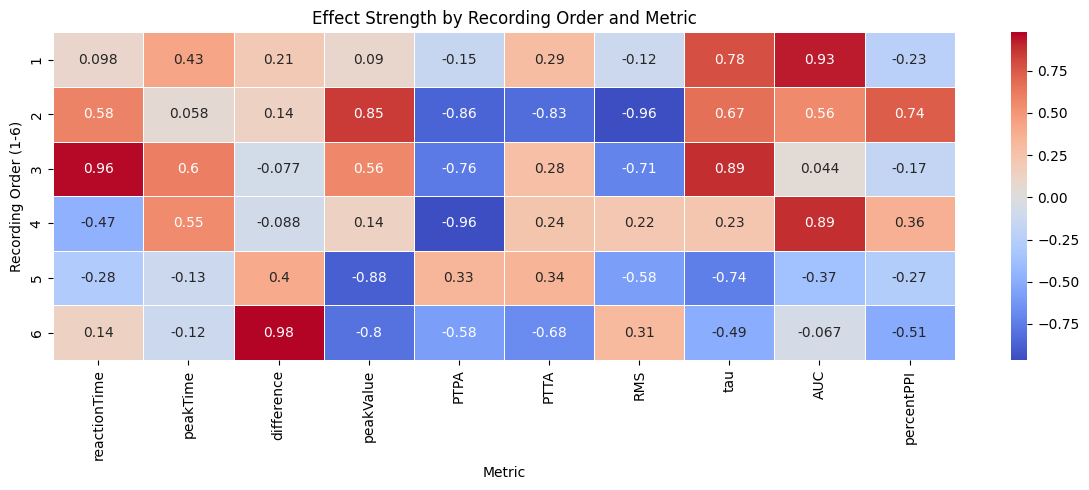

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: effect_strength for each metric and recording order (1-6)
# Replace with your actual results if available
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"]
recording_orders = [1, 2, 3, 4, 5, 6]

# Dummy data: shape (6, 10) for demonstration
np.random.seed(0)
effect_strength_matrix = np.random.uniform(-1, 1, size=(6, len(metrics)))

df = pd.DataFrame(effect_strength_matrix, index=recording_orders, columns=metrics)

plt.figure(figsize=(12, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Recording Order and Metric")
plt.ylabel("Recording Order (1-6)")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

# ---> strong effect of recording order

In [35]:
# Show direction of recording order effect for significant results

import pandas as pd

df = dfs['RESULTS_MERGED']

summary_rows = []
    
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                mean_early = vals_early.mean()
                mean_late = vals_late.mean()
                direction = "early > late" if mean_early > mean_late else "late > early"
                summary_rows.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'mean_early': mean_early,
                    'mean_late': mean_late,
                    'direction': direction,
                    'diff': mean_early - mean_late
                })

test_rec_order_direction = pd.DataFrame(summary_rows)
print(test_rec_order_direction)

test_rec_order_direction.to_excel(os.path.join(output_dir, "TEST_REC_ORDER_DIRECTION.xlsx"), index=False)

       sex     date metric    mean_early     mean_late     direction  \
0   female  April16    AUC     11.694118     11.219608  early > late   
1   female  April16    AUC     29.891176     30.664706  late > early   
2   female  April16    AUC     18.197059     19.445098  late > early   
3   female  April16    AUC     61.279412     66.462745  late > early   
4   female  April16    AUC     61.614882     66.811931  late > early   
5   female  April16    AUC     55.685074     58.529216  late > early   
6   female  April16    AUC     23.777324     26.980588  late > early   
7   female  April16    AUC    153.201324    160.571186  late > early   
8   female  April16    AUC   6125.470309   7294.271343  late > early   
9   female   June26    AUC     10.470588      9.464706  early > late   
10  female   June26    AUC     30.767647     30.252941  early > late   
11  female   June26    AUC     20.297059     20.788235  late > early   
12  female   June26    AUC    101.597059    116.444118  late > e

### ---> peakTime higher and reactionTime lower with less strength?

In [36]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['peakTime', 'reactionTime']

correlation_results = []

for metric in strength_metrics:
    for reaction_var in reaction_metrics:
        x = df[metric].dropna()
        y = df[reaction_var].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            # Pearson correlation (parametric)
            pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
            mean_diff = x_aligned.mean() - y_aligned.mean()
            correlation_results.append({
                'strength_metric': metric,
                'reaction_metric': reaction_var,
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'n': len(x_aligned),
                'mean_diff': mean_diff
            })

test_peakTime_reactionTime_to_strength_cor = pd.DataFrame(correlation_results)
print("Pearson correlation between strength metrics and peakTime/reactionTime:")
print(test_peakTime_reactionTime_to_strength_cor)

test_peakTime_reactionTime_to_strength_cor.to_excel(os.path.join(output_dir, "TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlation between strength metrics and peakTime/reactionTime:
   strength_metric reaction_metric  pearson_r     pearson_p    n     mean_diff
0        peakValue        peakTime   0.203179  3.475442e-04  306     92.742919
1        peakValue    reactionTime  -0.354613  1.696764e-10  306    112.627778
2             PTPA        peakTime   0.191496  7.590448e-04  306     92.654644
3             PTPA    reactionTime  -0.354644  1.690085e-10  306    112.539503
4             PTTA        peakTime   0.202557  3.626936e-04  306     80.567260
5             PTTA    reactionTime  -0.352337  2.257637e-10  306    100.452118
6              RMS        peakTime   0.267902  1.990603e-06  306     17.679835
7              RMS    reactionTime  -0.349559  3.189581e-10  306     37.564693
8              tau        peakTime   0.177751  1.799060e-03  306    107.839431
9              tau    reactionTime   0.117228  4.042984e-02  306    127.724290
10             AUC        peakTime   0.250875  8.921193e-06

## ---> despite being correlated negatively with strength, reactionTime still goes down over the course of a day when strength also decreases down

### ---> any other correlations?

In [37]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']

correlation_results = []

for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            continue
        x = df[var1].dropna()
        y = df[var2].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'n': len(x_aligned)
            })

all_var_correlations = pd.DataFrame(correlation_results)
print("Pearson correlation for all variable pairs:")
print(all_var_correlations)

all_var_correlations.to_excel(os.path.join(output_dir, "ALL_VAR_CORRELATIONS_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlation for all variable pairs:
            var1        var2  pearson_r      pearson_p    n
0   reactionTime    peakTime  -0.106997   6.156904e-02  306
1   reactionTime  difference  -0.490310   6.514153e-20  306
2   reactionTime   peakValue  -0.354613   1.696764e-10  306
3   reactionTime        PTPA  -0.354644   1.690085e-10  306
4   reactionTime        PTTA  -0.352337   2.257637e-10  306
..           ...         ...        ...            ...  ...
67           AUC   peakValue   0.880769  1.059261e-100  306
68           AUC        PTPA   0.879421  5.253820e-100  306
69           AUC        PTTA   0.878667   1.276119e-99  306
70           AUC         RMS   0.954175  2.476864e-161  306
71           AUC         tau   0.085423   1.359858e-01  306

[72 rows x 5 columns]


In [38]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']
correlation_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var1 in variables:
            for var2 in variables:
                if var1 == var2:
                    continue
                x = df_sub[var1].dropna()
                y = df_sub[var2].dropna()
                # Align indices to avoid mismatches
                common_idx = x.index.intersection(y.index)
                x_aligned = x.loc[common_idx]
                y_aligned = y.loc[common_idx]
                if len(x_aligned) > 2:
                    pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
                    correlation_results.append({
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'n': len(x_aligned)
                    })

correlations_by_sex_date_parametric = pd.DataFrame(correlation_results)
print("Pearson correlations split by sex and date:")
print(correlations_by_sex_date_parametric)

# Count significant correlations (p < 0.05)
significant_corr_count = (correlations_by_sex_date_parametric['pearson_p'] < 0.05).sum()
print(f"Number of significant correlations found (p < 0.05): {significant_corr_count}")

correlations_by_sex_date_parametric.to_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlations split by sex and date:
        sex     date          var1        var2  pearson_r     pearson_p   n
0    female  April16  reactionTime    peakTime  -0.022446  8.757625e-01  51
1    female  April16  reactionTime  difference  -0.624589  9.665228e-07  51
2    female  April16  reactionTime   peakValue  -0.678968  4.337986e-08  51
3    female  April16  reactionTime        PTPA  -0.679567  4.176909e-08  51
4    female  April16  reactionTime        PTTA  -0.651686  2.224441e-07  51
..      ...      ...           ...         ...        ...           ...  ..
427    male    May20           AUC   peakValue   0.792707  4.148497e-12  51
428    male    May20           AUC        PTPA   0.790691  5.128008e-12  51
429    male    May20           AUC        PTTA   0.725302  1.745348e-09  51
430    male    May20           AUC         RMS   0.973777  3.615346e-33  51
431    male    May20           AUC         tau   0.887523  4.117194e-18  51

[432 rows x 7 columns]
Number of significan

C:\Users\Galahad\AppData\Local\Temp\ipykernel_21852\2571273719.py:32: RuntimeWarning: Mean of empty slice
  avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)


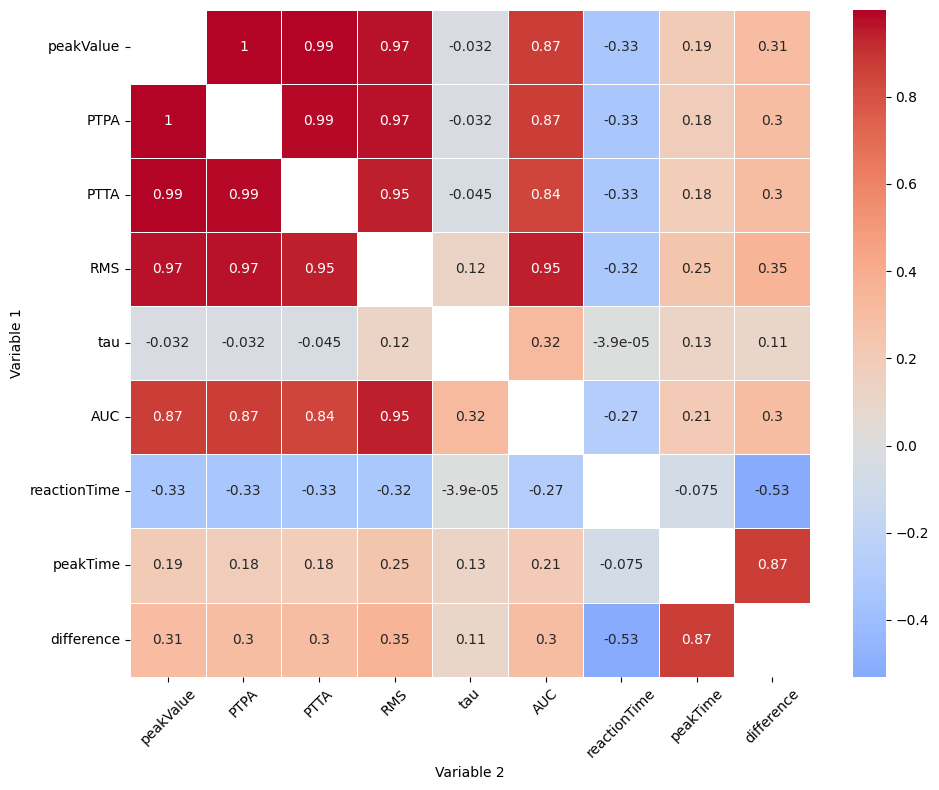

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the correlations_by_sex_date results (should use Pearson's r, not Spearman)
cor_df = pd.read_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE_PARAMETRIC.xlsx"))

# Use all correlations, not just significant ones, and use Pearson's r
# If your file uses 'pearson_r' and 'pearson_p', update column names accordingly
if 'pearson_r' in cor_df.columns:
    r_col = 'pearson_r'
    p_col = 'pearson_p'
else:
    r_col = 'spearman_r'
    p_col = 'spearman_p'

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in variables if v not in strength_metrics]
var_order = strength_metrics + [v for v in variables if v not in strength_metrics]

# Pivot for each group and average
pivoted = []
for (sex, date), group in cor_df.groupby(['sex', 'date']):
    mat = group.pivot(index="var1", columns="var2", values=r_col)
    mat = mat.reindex(index=var_order, columns=var_order)
    pivoted.append(mat)

# Stack and average, ignoring NaNs
avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_heatmap_df = pd.DataFrame(avg_heatmap, index=var_order, columns=var_order)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_heatmap_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

---

## Experiment Differences

In [40]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                          if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'ANOVA',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna().values for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = f_oneway(*groups)
                if p < 0.05:
                    try:
                        tukey = sp.posthoc_tukey_hsd(df_sub[df_sub['experiment'].isin(valid_exps)],
                                                     val_col=var, group_col='experiment')
                        min_p = tukey.replace(0, float('nan')).min().min()
                        idx = tukey.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        mean_diff = vals1.mean() - vals2.mean()
                        pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                        eff = mean_diff / pooled_std if pooled_std != 0 else None
                        posthoc_p = min_p
                        posthoc_test = "Tukey HSD"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'ANOVA',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (parametric, ANOVA):")
print(test_experiment)

test_experiment.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Experiment effects on all variables (parametric, ANOVA):
       sex     date      variable   test      stat         p  significant  \
0   female  April16  reactionTime  ANOVA  1.556423  0.136440        False   
1   female  April16      peakTime  ANOVA  0.808990  0.666730        False   
2   female  April16    difference  ANOVA  0.792863  0.682980        False   
3   female  April16     peakValue  ANOVA  0.633884  0.833704        False   
4   female  April16          PTPA  ANOVA  0.645002  0.824128        False   
5   female  April16          PTTA  ANOVA  0.628099  0.838605        False   
6   female  April16           RMS  ANOVA  0.813932  0.661742        False   
7   female  April16           tau  ANOVA  1.032994  0.449541        False   
8   female  April16           AUC  ANOVA  0.784632  0.691249        False   
9   female   June26  reactionTime  ANOVA  0.588330  0.870636        False   
10  female   June26      peakTime  ANOVA  0.783544  0.692341        False   
11  female   June26

In [41]:
# Count significant experiment pair differences for ALL metrics, split by sex and date, using parametric testing (t-test, assume normality).
# Print only the counts, both total and those NOT involving 'tone_in_noise'.

import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        total_sig = 0
        total_sig_not_tone = 0
        for metric in metrics:
            for i, exp1 in enumerate(experiments):
                for exp2 in experiments[i+1:]:
                    vals1 = df_sub[df_sub['experiment'] == exp1][metric].dropna()
                    vals2 = df_sub[df_sub['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = ttest_ind(vals1, vals2, equal_var=False)
                        if p < 0.05:
                            total_sig += 1
                            if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                                total_sig_not_tone += 1
        print(f"Sex: {sex}, Date: {date}")
        print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig}")
        print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Sex: female, Date: April16
  Total significant experiment pairs (all metrics, t-test): 29
  Significant pairs NOT involving 'tone_in_noise': 14


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Sex: female, Date: June26
  Total significant experiment pairs (all metrics, t-test): 18
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: May20
  Total significant experiment pairs (all metrics, t-test): 2
  Significant pairs NOT involving 'tone_in_noise': 2
Sex: male, Date: April16
  Total significant experiment pairs (all metrics, t-test): 5
  Significant pairs NOT involving 'tone_in_noise': 5
Sex: male, Date: June26
  Total significant experiment pairs (all metrics, t-test): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: May20
  Total significant experiment pairs (all metrics, t-test): 8
  Significant pairs NOT involving 'tone_in_noise': 1


In [42]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = ttest_ind(vals1, vals2, equal_var=False)
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, t-test): 30 out of 1224
  Significant pairs NOT involving 'tone_in_noise': 0 out of 1080

  Significant experiment pairs by metric:
    peakValue: gap_depth vs tone_in_noise (p=2.340e-02)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.228e-02)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.263e-02)
    peakValue: tone_in_noise vs gap_duration_20 (p=9.025e-03)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.460e-02)
    peakValue: tone_in_noise vs offset_PPI_50 (p=4.642e-02)
    PTPA: gap_depth vs tone_in_noise (p=2.186e-02)
    PTPA: tone_in_noise vs gap_duration_4 (p=1.179e-02)
    PTPA: tone_in_noise vs gap_duration_10 (p=1.210e-02)
    PTPA: tone_in_noise vs gap_duration_20 (p=8.124e-03)
    PTPA: tone_in_noise vs gap_duration_50 (p=1.471e-02)
    PTPA: tone_in_noise vs offset_PPI_50 (p=4.407e-02)
    PTTA: gap_depth vs tone_in_noise (p=2.107e-02)
    PTTA: tone_in_noise vs gap_duration_4 (

In [43]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = ttest_ind(vals1, vals2, equal_var=False)
                    mean_diff = vals1.mean() - vals2.mean()
                    n1, n2 = len(vals1), len(vals2)
                    # Cohen's d for effect size
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    eff_strength = mean_diff / pooled_std if pooled_std != 0 else None
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p, mean_diff, eff_strength))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p, mean_diff, eff_strength in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e}, mean_diff={mean_diff:.2f}, eff_strength={eff_strength:.3f})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, t-test): 30 out of 1224
  Significant pairs NOT involving 'tone_in_noise': 0 out of 1080

  Significant experiment pairs by metric:
    peakValue: gap_depth vs tone_in_noise (p=2.340e-02, mean_diff=28.27, eff_strength=1.207)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.228e-02, mean_diff=-34.90, eff_strength=-1.379)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.263e-02, mean_diff=-29.12, eff_strength=-1.346)
    peakValue: tone_in_noise vs gap_duration_20 (p=9.025e-03, mean_diff=-32.33, eff_strength=-1.433)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.460e-02, mean_diff=-30.73, eff_strength=-1.322)
    peakValue: tone_in_noise vs offset_PPI_50 (p=4.642e-02, mean_diff=-23.04, eff_strength=-1.031)
    PTPA: gap_depth vs tone_in_noise (p=2.186e-02, mean_diff=28.16, eff_strength=1.223)
    PTPA: tone_in_noise vs gap_duration_4 (p=1.179e-02, mean_diff=-35.08, eff_strength=-1.390)
    PTPA: to

In [44]:
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, PARAMETRIC) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        # Compare all underlying experiment pairs in each merged group
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = ttest_ind(v1, v2, equal_var=False)
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Print p-value range instead of average
                        if p_vals and min(p_vals) < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, PARAMETRIC) ---
female, peakValue: gap_depth vs tone_in_noise | stat_range=(2.56-2.56), p_range=(2.340e-02-2.340e-02), mean_diff_range=(28.27-28.27)
female, PTPA: gap_depth vs tone_in_noise | stat_range=(2.59-2.59), p_range=(2.186e-02-2.186e-02), mean_diff_range=(28.16-28.16)
female, PTTA: gap_depth vs tone_in_noise | stat_range=(2.61-2.61), p_range=(2.107e-02-2.107e-02), mean_diff_range=(26.24-26.24)
female, RMS: gap_depth vs tone_in_noise | stat_range=(2.62-2.62), p_range=(2.144e-02-2.144e-02), mean_diff_range=(12.31-12.31)
female, AUC: gap_depth vs tone_in_noise | stat_range=(2.34-2.34), p_range=(3.594e-02-3.594e-02), mean_diff_range=(2937.41-2937.41)
female, peakValue: gap_duration vs tone_in_noise | stat_range=(2.01-3.04), p_range=(9.025e-03-6.601e-02), mean_diff_range=(22.43-34.90)
female, PTPA: gap_duration vs tone_in_noise | stat_range=(2.03-3.09), p_range=(8.124e-03-6.332e-02), mean_diff_range=(22.58-35.08)
female, PTTA: gap_du

In [45]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MERGED']
exclude_metrics = ['PTPA', 'PTTA', 'RMS', 'AUC']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI'] + exclude_metrics]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Only print if at least one p-value is significant and none are exactly 1.0
                        if p_vals and min(p_vals) < 0.05 and not any(abs(p - 1.0) < 1e-10 for p in p_vals):
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female, peakValue: gap_depth vs tone_in_noise | stat_range=(63.50-63.50), p_range=(4.683e-02-4.683e-02), mean_diff_range=(28.27-28.27)
female, peakValue: gap_duration vs tone_in_noise | stat_range=(60.50-70.00), p_range=(1.044e-02-8.493e-02), mean_diff_range=(22.43-34.90)
male, reactionTime: gap_depth vs offset_PPI | stat_range=(16.00-32.00), p_range=(2.607e-02-4.638e-01), mean_diff_range=(-0.84-0.16)
male, reactionTime: gap_duration vs tone_in_noise | stat_range=(57.50-63.00), p_range=(4.196e-02-1.272e-01), mean_diff_range=(1.42-1.81)
male, reactionTime: offset_PPI vs tone_in_noise | stat_range=(54.50-66.50), p_range=(2.253e-02-2.296e-01), mean_diff_range=(1.08-2.08)
male, difference: offset_PPI vs tone_in_noise | stat_range=(14.00-35.00), p_range=(2.028e-02-6.567e-01), mean_diff_range=(-2.88--0.97)

--- OFFSET_PPI (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female, peak

In [46]:
import pandas as pd

df = dfs['RESULTS_MERGED']

results = []
for sex in df['sex'].unique():
    # Merge across all dates for each sex
    df_sex = df[df['sex'] == sex]
    vals_tone = df_sex[df_sex['experiment'] == 'tone_in_noise']['reactionTime'].dropna()
    vals_other = df_sex[df_sex['experiment'] != 'tone_in_noise']['reactionTime'].dropna()
    mean_tone = vals_tone.mean() if len(vals_tone) > 0 else None
    mean_other = vals_other.mean() if len(vals_other) > 0 else None
    diff = mean_other - mean_tone if mean_tone is not None and mean_other is not None else None

    # Also check peakValue
    vals_tone_peak = df_sex[df_sex['experiment'] == 'tone_in_noise']['peakValue'].dropna()
    vals_other_peak = df_sex[df_sex['experiment'] != 'tone_in_noise']['peakValue'].dropna()
    mean_tone_peak = vals_tone_peak.mean() if len(vals_tone_peak) > 0 else None
    mean_other_peak = vals_other_peak.mean() if len(vals_other_peak) > 0 else None
    diff_peak = mean_other_peak - mean_tone_peak if mean_tone_peak is not None and mean_other_peak is not None else None

    results.append({
        'sex': sex,
        'mean_reaction_time_tone_in_noise': mean_tone,
        'mean_reaction_time_other': mean_other,
        'difference_reaction_time_ms': diff,
        'mean_peakvalue_tone_in_noise': mean_tone_peak,
        'mean_peakvalue_other': mean_other_peak,
        'difference_peakvalue': diff_peak
    })

result_df = pd.DataFrame(results)
print(result_df)
result_df.to_excel(os.path.join(output_dir, "REACTION_PEAKVALUE_TONE_IN_NOISE_DIFF_MERGED_DATE.xlsx"), index=False)

      sex  mean_reaction_time_tone_in_noise  mean_reaction_time_other  \
0  female                          9.544444                 10.813426   
1    male                          8.811111                 10.496528   

   difference_reaction_time_ms  mean_peakvalue_tone_in_noise  \
0                     1.268981                     67.694444   
1                     1.685417                    134.474074   

   mean_peakvalue_other  difference_peakvalue  
0             89.772106             22.077662  
1            159.383565             24.909491  


In [47]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def get_exp_value(exp, prefix):
    if exp.startswith(prefix):
        return exp.split('_')[-1]
    return None

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        exps = sorted({e for e in df_sex['experiment'].unique() if e.startswith(exp_prefix)})
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                label1 = get_exp_value(exp1, exp_prefix)
                label2 = get_exp_value(exp2, exp_prefix)
                for metric in metrics:
                    vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        mean_diff = vals1.mean() - vals2.mean()
                        if p < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat={stat:.2f}, p={p:.3e}, mean_diff={mean_diff:.2f}")


--- GAP_DURATION (DATES MERGED) ---

--- OFFSET_PPI (DATES MERGED) ---


---

## ---> maybe merge for date anyways?

In [48]:
# Test for experiment effect on peakValue (all dates merged, split by sex)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    experiments = df_sex['experiment'].unique().tolist()
    groups = [df_sex[df_sex['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
    groups = [g for g in groups if len(g) > 1]
    print(f"\nSex: {sex}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
        print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
        if p < 0.05:
            print("Significant experiment effect found.")
            try:
                dunn = sp.posthoc_dunn(df_sex, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                print("Dunn's post hoc p-values (experiment pairs):")
                print(dunn)
            except Exception as e:
                print("Post hoc test failed:", e)
        else:
            print("No significant experiment effect found.")
    else:
        print("Not enough data for experiment effect test.")


Sex: female
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 14.330, p-value = 5.741e-01
No significant experiment effect found.

Sex: male
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 6.665, p-value = 9.792e-01
No significant experiment effect found.


In [49]:
# Test for experiment effect on peakValue (merged by sex, split by date)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for sex in df_date['sex'].unique():
        df_sex_date = df_date[df_date['sex'] == sex]
        experiments = df_sex_date['experiment'].unique().tolist()
        groups = [df_sex_date[df_sex_date['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
        groups = [g for g in groups if len(g) > 1]
        print(f"\nDate: {date}, Sex: {sex}")
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):")
            print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
            if p < 0.05:
                print("Significant experiment effect found.")
                try:
                    dunn = sp.posthoc_dunn(df_sex_date, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                    print("Dunn's post hoc p-values (experiment pairs):")
                    print(dunn)
                except Exception as e:
                    print("Post hoc test failed:", e)
            else:
                print("No significant experiment effect found.")
        else:
            print("Not enough data for experiment effect test.")


Date: April16, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 11.791, p-value = 7.583e-01
No significant experiment effect found.

Date: April16, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 14.869, p-value = 5.343e-01
No significant experiment effect found.

Date: June26, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 12.481, p-value = 7.103e-01
No significant experiment effect found.

Date: June26, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.490, p-value = 9.819e-01
No significant experiment effect found.

Date: May20, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.182, p-value = 9.860e-01
No significant experiment effect found.

Date: May20, Sex: male
Kruskal-Wallis test for experiment effect

In [50]:
# Test for experiment effect on peakValue (all dates merged, all experiments)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']


# Gather peakValue for each experiment (merged across all dates)
groups = [df[df['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
groups = [g for g in groups if len(g) > 1]

# Kruskal-Wallis test for experiment effect
if len(groups) > 1:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
    print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
    if p < 0.05:
        print("Significant experiment effect found.")
        # Dunn's post hoc test
        try:
            dunn = sp.posthoc_dunn(df, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (experiment pairs):")
            print(dunn)
        except Exception as e:
            print("Post hoc test failed:", e)
    else:
        print("No significant experiment effect found.")
else:
    print("Not enough data for experiment effect test.")

Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 9.738, p-value = 8.800e-01
No significant experiment effect found.


# ---> no overall significant effect of experiment on any metric, only in comparison between singular experiments do differences show

---